# GGS 416 - API Image Extraction

This tutorial will move to a more advanced topic: Automated extraction of imagery.

Whereas in the previous class we manually extracted satellite imagery from various sources (e.g. Earth Explorer), today we will focus on how to automatically extract satellite imagery from an Application Programming Interface (API).

You may be surprised to find that you already engage with APIs on a daily basis when carrying out your online activity!

## What is an API?

Collecting satellite imagery via an API makes the process of image collection much easier and more efficient - thankfully!

Although there can be a bit of a leap in terms of technical understanding, especially if you haven't used Python much before. 

Consequently, this entire lecture is spent helping you understand how to extract imagery via an API. 

APIs let a product or service communicate with other products and services without needing to know specifically how each one works. Metaphorically, APIs are sometimes thought of as contracts, with documentation that represents an agreement between parties: If party 1 sends a remote request structured in a particular way, this is how party 2’s software will respond. 

For example, we send a request for certain satellite images to a server holding imagery data, and the requested data is collected on the server, processed, potentially compressed, and then sent (probably over a computer network such as the Internet) to our machine. We do not need to know how the server is setup or operating to make this request. And the server owner can completely change the server setup and operation, without us needing to change our code, all thanks to our handy API. 

Essentially, APIs in this case simplify how we connect to an existing computer infrastructure. Indeed, public APIs in general represent unique societal value because they can simplify and expand how we all connect with data (e.g. the Google Maps API is a popular example).

Watch the video overview below to get more of a flavor:

In [2]:
%%HTML

<iframe width="560" height="315" src="https://www.youtube.com/embed/s7wmiS2mSXY" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

# Sentinelsat

`Sentinelsat` provides us with a very flexible and easy-to-use API which we can use to search, download and retrieve Sentinel satellite images and metadata via the Copernicus Open Access Hub.

See here the codebase available in this Github repo: https://github.com/sentinelsat/sentinelsat
       
They also make a handy readthedocs page available which contains all the info you need to get started in extracting Sentinel-2 imagery: https://sentinelsat.readthedocs.io/en/stable/

## Installation

First, you need to install the `sentinelsat` package in your current environment. 

Just to recap, make sure you activated your conda environment before taking this step, as you want to make sure you install `sentinelsat` in there (e.g. in the `sia` conda environment).


In [3]:
import sys
!{sys.executable} -m pip install sentinelsat

#### Alternatively, you may install `sentinelsat` in the command line prior to running this notebook, thereby circumventing the above executable within your notebook itself (and in this way, avoid altering your native system environment with the `pip` command, modify the current conda-activated environment, and provide a more focused version-control approach):

Prior to running the notebook session, run the following commands in the command line interface (CLI; Terminal):
<br>
`conda activate ggs416env` #conda environment activatation
<br>
`conda install -c conda-forge sentinelsat` #sentinelsat package installation
<br>
`jupyter notebook` #open notebook session in browser
<br>

When notebook session opens in the browser, **ensure proper kernel is activated in upper-right corner** (i.e., your conda environment; in this example, Python 3 (ggs416env)). Then, begin importing the pertinent packages required for your queries/analyses. In this scenario, import `sentinelsat` in the first line of the notebook with the following code:
<br>
`import sentinelsat` #import sentinelsat package in 


In [4]:
import sentinelsat

## Required functions

Now you've managed to install `sentinelsat`, we need to import any required package functions which include:
- `SentinelAPI` - Class to connect to Copernicus Open Access Hub, search and download imagery. 
- `read_geojson` - Read a GeoJSON file into a GeoJSON object.
- `geojson_to_wkt` - Convert a GeoJSON object to Well-Known Text. Intended for use with OpenSearch queries. 3D points are converted to 2D.

(see the API reference here for all functions: https://sentinelsat.readthedocs.io/en/stable/api_reference.html)

Let's now import them into our current notebook session:

In [5]:
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date

## Registration

You then need to register for the Copernicus Scihub so you have an access account for imagery. 

https://scihub.copernicus.eu/dhus/#/home

Once you've complete this process, you should have a username and a password. Keep these handy, you will need both of them below. 


## API object
We are now going to create an object called `api` using the `SentinelAPI` function. 

You will need to provide your username and password. 

This is so that when you eventually send your request to the server, the server knows who you are, via your existing account. 

In [6]:
api = SentinelAPI('your_username_here', 'your_password_here')
api 

## Bounding box geometry

Next we need to specify a geometry for the area where we want to extract the imagery.

For familiarity, let's create a bounding box around GMU's campus.

You can find the actual shape file in the github repo folder `shapes`.

We will produce a GeoJSON object from the bounding box you see below.

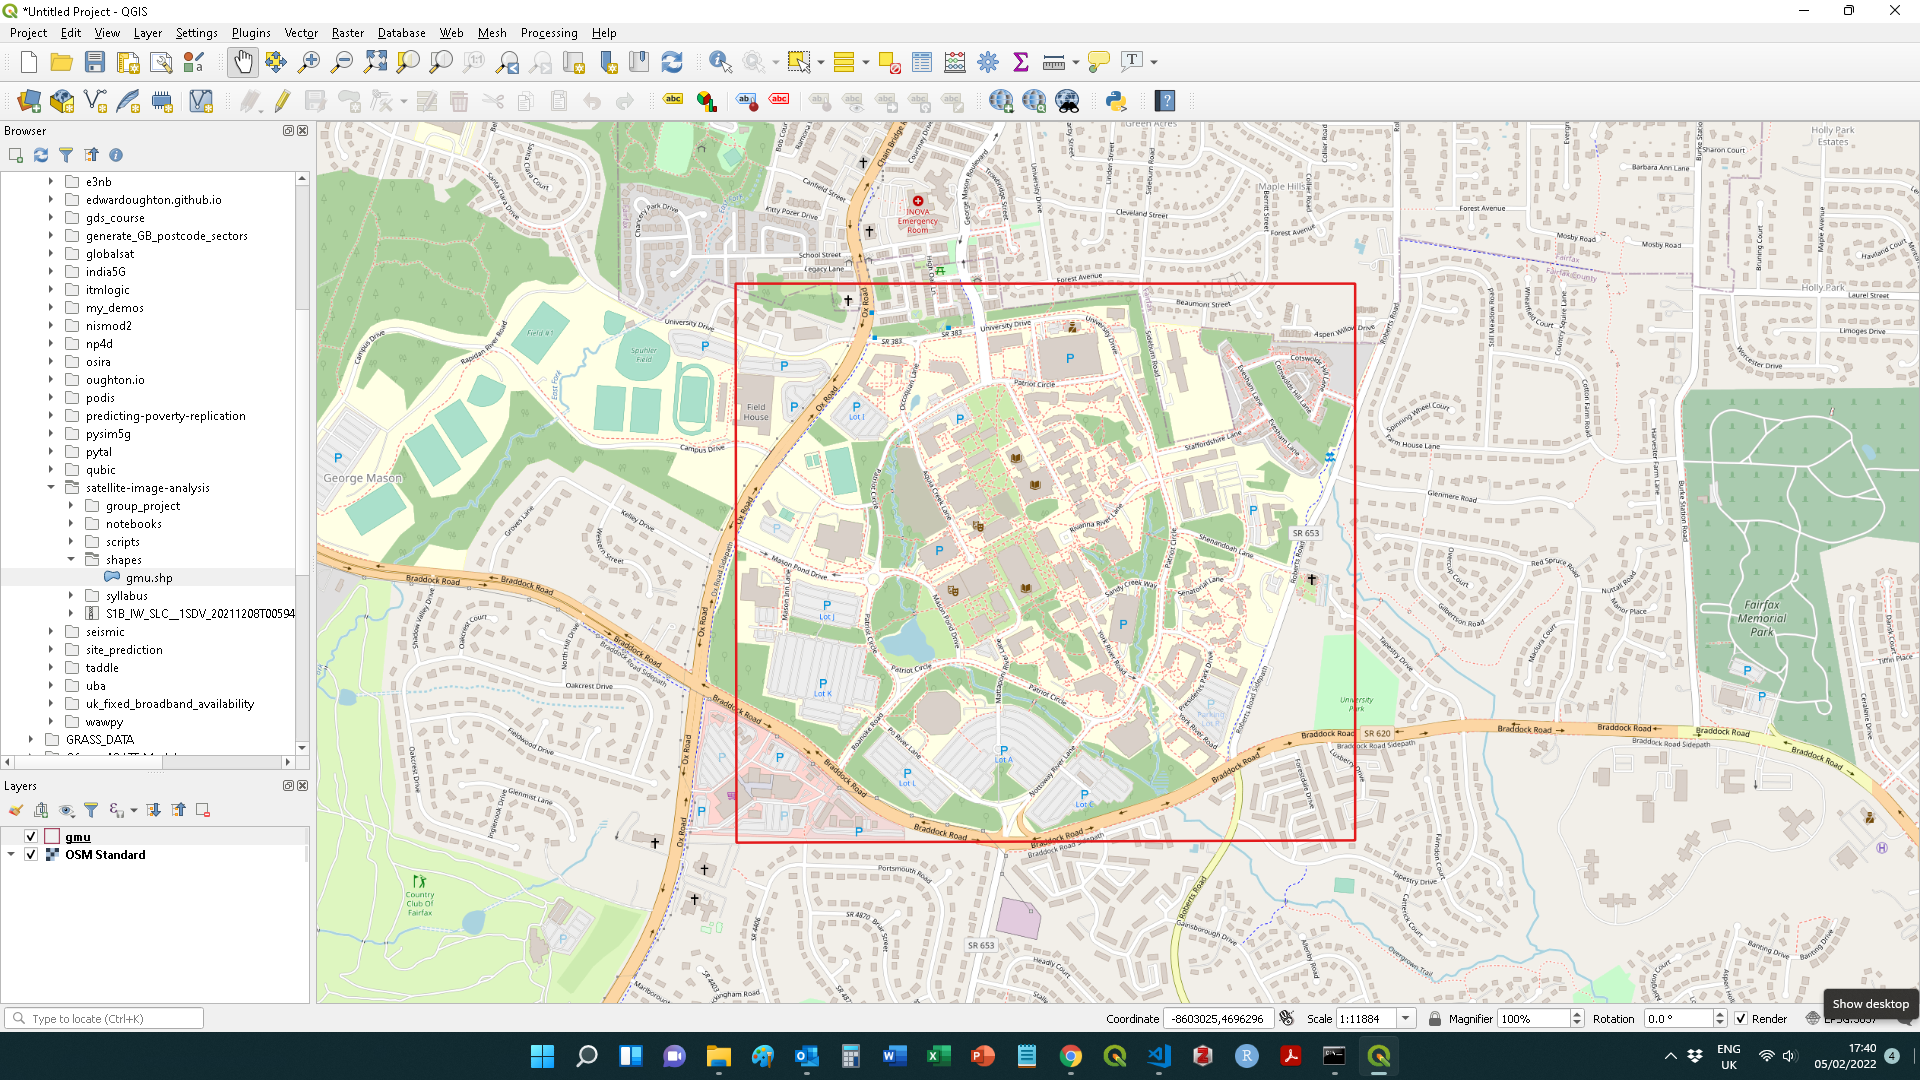

In [7]:
from IPython.display import Image
Image("images/gmu.png")

### The GeoJSON structure 

GeoJSON is a format for encoding a variety of geographic data structures.

GeoJSON supports the following geometry types: Point, LineString, Polygon, MultiPoint, MultiLineString, and MultiPolygon. Geometric objects with additional properties are Feature objects. Sets of features are contained by FeatureCollection objects.

https://geojson.org/


### The GeoJSON Specification (RFC 7946)

In 2015, the Internet Engineering Task Force (IETF), in conjunction with the original specification authors, formed a GeoJSON WG to standardize GeoJSON. RFC 7946 was published in August 2016 and is the new standard specification of the GeoJSON format, replacing the 2008 GeoJSON specification.

In [8]:
# Example

# Here is a point locating GMU's Exploratory Hall
my_point = {
  "type": "Feature", 
  "geometry": {
    "type": "Point",
    "coordinates": [-77.305626, 38.829897]
  },
  "properties": {
    "name": "Exploratory Hall"
  }
}
my_point

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [-77.305626, 38.829897]},
 'properties': {'name': 'Exploratory Hall'}}

You can see that each GeoJSON includes:
- `type` which specifies if the GeoJSON is either a Feature or FeatureCollection.
- `geometry` which contains:
    - `type` referring to seven case-sensitive strings, either "Point", "MultiPoint", "LineString", "MultiLineString", "Polygon", "MultiPolygon", and "GeometryCollection".
    - `coordinates` an array containing the all important geographic coordinates.
- `properties` which contains any affiliated information e.g. an object identifier

Let us now define our polygon bounding box of GMU as a GeoJSON format:

In [13]:
my_geojson = {
  "type": "Feature", #let's define our GeoJSON type. As it's a single geometry, it's just a single 'Feature'
  "geometry": {
	"type": "Polygon", #let's define our geometry type, which as we have a square, is a polygon.
	"coordinates": [ #Here are our actual geometry coordinates
	  [
		[
		  -77.3153999999999968,
		  38.8239999999999981
		],
		[
		  -77.2956694620074671,
		  38.8239999999999981
		],
		[
		  -77.2956694620074671,
		  38.8392882996798647
		],
		[
		  -77.3153999999999968,
		  38.8392882996798647
		],
		[
		  -77.3153999999999968,
		  38.8239999999999981
		]
	  ],
	]
  },
    "properties": {'id': 'GMU'}, #And an example geometry ID, although not strictly necessary for this task
}

my_geojson

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-77.3154, 38.824],
    [-77.29566946200747, 38.824],
    [-77.29566946200747, 38.839288299679865],
    [-77.3154, 38.839288299679865],
    [-77.3154, 38.824]]]},
 'properties': {'id': 'GMU'}}

We can check that our geojson shape is correct by writing out to a shapefile. You can open this shapefile in a piece of GIS software to ensure it is geolocated on your desired location.

In [12]:
import geopandas as gpd

my_geojson_to_write = []
my_geojson_to_write.append(my_geojson)

## Now we can specify a GeoDataFrame, providing the list of dicts and the CRS.
my_geojson_to_write = gpd.GeoDataFrame.from_features(my_geojson_to_write, crs='epsg:4326') #3857

## Finally, let's write this GeoDataFrame to a shapefile. 
my_geojson_to_write.to_file('my_geojson_to_write.shp', crs='epsg:4326')

### Converting GeoJSON to WKT 

We will now convert our GeoJSON format into a Well Known Text (WKT) format. 

"Well-known text is a text markup language for representing vector geometry objects. A binary equivalent, known as well-known binary, is used to transfer and store the same information in a more compact form convenient for computer processing but that is not human-readable"

https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry

Thus, we are converting from our human-readable GeoJSON into our WKT machine-readable format using the `geojson_to_wkt` function.




In [ ]:
footprint = geojson_to_wkt(my_geojson)
footprint

### The API query

Now we can begin specifying the API query.

We call the `api` object that we already specified and:
- Provide the `footprint` polygon object we just specified as the area we want imagery for.
- Define the platform name.
- State the date range we want the imagery between
- State the cloud cover range. So for (0,10) we want images with less then 10% cloud cover. 
- Limit the maximum number of products returned (to reduce the file size)

**Importantly, downloading imagery can take a very long time, so it's best to get started with a small date range until you know its working correctly on your own machine.**


In [ ]:
# Specify the products and associated characteristics
products = api.query(
    footprint,
    platformname = 'Sentinel-2',
    date = ('20210701', '20210715'),
    cloudcoverpercentage = (0,10),
    limit=1
)

# Now download them!!
api.download_all(products)

## Unzipping your downloaded imagery

Before you can begin using your imagery, you should unzip and correctly file your data. 

In the code below you have all the basic processing to:

- Obtain the name of all files in your directory.
- Create a new list to hold the filenames for the files to be unzipped.
- Loop over all files and append only those that are .zip to the new list.
- Create a new folder called `unzipped` for your data, if it doesn't already exist.
- Loop over your files, extracting the data and placing them in the `unzipped` folder. 
- Remove the .zip files once unpacked.


In [ ]:
import os
import zipfile

# Get a list of all filenames in our directory
all_filenames_in_folder = os.listdir() 

# Create an empty list for the filenames we want to unzip
filenames_to_unzip = []

# Loop over filenames and put .zip files in our list
for filename in all_filenames_in_folder:
    if filename.endswith('.zip'): # Only let .zip files append 
        filenames_to_unzip.append(filename)

# Let's create a new folder for our unzipped files
folder = 'unzipped'
if not os.path.exists(folder):
    os.mkdir(folder) # Make the folder if it does not exist 

for filename in filenames_to_unzip:
    
    # Unzip the zip file and put it in the 'unzipped' folder
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(folder)

    os.remove(filename)

## Wrapping up

Once complete, you should be all set to begin exploring your Sentinel-2 imagery - woohoo!

So congratulations, you completed the API tutorial.

This is not an easy topic to get to grips with, but is incredibly powerful if you can learn to master it.

Now you should have a good tool to utilize in your group coursework projects for GGS416.

In the next lecture, we will get into viewing and processing this satellite imagery. 

See you there!
